# Student Performance Analytics — Portfolio Notebook (Star Edition)

A compact, professional analysis built around a **student performance dataset** (Excel).  
If the Excel file is not found, the notebook falls back to a **high‑fidelity synthetic dataset** so the workflow remains fully reproducible.

What you will see:
- Data intake + schema checks
- Descriptive statistics + data quality review
- Correlations focused on **absences**
- Grouped summaries (school, gender, guardian, travel time)
- Contingency table for **perfect attendance** vs parents’ education
- Portfolio‑grade visuals
- A lightweight predictive baseline for **final grade (G3)** (optional modeling section)
- Exported figures for reuse in a second deliverable



In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

print("Seed:", RANDOM_SEED)
print("Working dir:", os.getcwd())

print("\nFiles in current directory:")
for f in sorted(os.listdir(".")):
    if f.lower().endswith((".xlsx", ".csv", ".ipynb")):
        print("-", f)

Seed: 42
Working dir: /mnt/data

Files in current directory:
- LaLiga_Analytics_Portfolio_Star_EXECUTED.ipynb
- LaLiga_Portfolio_STAR_SYNTHETIC_EXECUTED.ipynb
- LaLiga_Star_Portfolio_EXECUTED_v2.ipynb
- Student_Performance_Analytics_STAR_Portfolio_EXECUTED.ipynb
- Student_Performance_Portfolio_Lab3_Style_EXECUTED.ipynb
- Urban_Waste_Analytics_Portfolio.ipynb
- Urban_Waste_Analytics_Portfolio_EXECUTED.ipynb
- Urban_Waste_Analytics_Portfolio_EXECUTED_EN.ipynb
- Urban_Waste_Analytics_Portfolio_EXECUTED_EN_ALLPRINTS.ipynb
- Urban_Waste_Analytics_Portfolio_EXECUTED_v2.ipynb


## 1) Load the Excel dataset (auto-detect)

In [2]:
# Priority order: explicit names first, otherwise the first .xlsx found.
PREFERRED = ["Tarea3.xlsx", "Tarea 3.xlsx", "Laboratorio3.xlsx", "Lab3.xlsx"]

xlsx_files = [f for f in os.listdir(".") if f.lower().endswith(".xlsx")]
chosen = None

for name in PREFERRED:
    if name in xlsx_files:
        chosen = name
        break

if chosen is None and xlsx_files:
    chosen = sorted(xlsx_files)[0]

def generate_synthetic_student_data(n=395, seed=42):
    rng = np.random.default_rng(seed)

    school = rng.choice(["GP", "MS"], size=n, p=[0.78, 0.22])
    sex = rng.choice(["F", "M"], size=n, p=[0.55, 0.45])
    guardian = rng.choice(["mother", "father", "other"], size=n, p=[0.70, 0.23, 0.07])

    age = rng.integers(15, 23, size=n)
    traveltime = rng.choice([1, 2, 3, 4], size=n, p=[0.62, 0.26, 0.09, 0.03])
    Medu = rng.choice([0, 1, 2, 3, 4], size=n, p=[0.05, 0.22, 0.30, 0.28, 0.15])
    Fedu = rng.choice([0, 1, 2, 3, 4], size=n, p=[0.06, 0.24, 0.32, 0.25, 0.13])

    # Latent academic ability
    ability = (
        0.55 * (Medu / 4)
        + 0.45 * (Fedu / 4)
        - 0.18 * (traveltime - 1)
        + rng.normal(0, 0.18, size=n)
    )
    ability = np.clip(ability, -0.5, 1.2)

    # Absences: overdispersed + slightly higher with travel time and age
    lam = 4.8 + 1.0 * (traveltime - 1) + 0.25 * (age - 17)
    absences = rng.poisson(lam=np.clip(lam, 0.5, 20.0)).astype(int)
    absences[rng.random(n) < 0.10] = 0
    absences = np.clip(absences, 0, 75)

    # Grades: correlated structure
    base_grade = 8.0 + 10.0 * ability
    G1 = np.clip(np.round(base_grade + rng.normal(0, 2.2, size=n) - 0.03 * absences), 0, 20).astype(int)
    G2 = np.clip(np.round(0.55 * G1 + 0.45 * (base_grade + rng.normal(0, 2.0, size=n)) - 0.02 * absences), 0, 20).astype(int)
    G3 = np.clip(np.round(0.50 * G2 + 0.50 * (base_grade + rng.normal(0, 2.2, size=n)) - 0.02 * absences), 0, 20).astype(int)

    df = pd.DataFrame({
        "school": school,
        "sex": sex,
        "age": age,
        "traveltime": traveltime,
        "guardian": guardian,
        "Medu": Medu,
        "Fedu": Fedu,
        "absences": absences,
        "G1": G1,
        "G2": G2,
        "G3": G3,
        "studytime": rng.choice([1,2,3,4], size=n, p=[0.35,0.40,0.18,0.07]),
        "failures": rng.choice([0,1,2,3], size=n, p=[0.75,0.16,0.06,0.03]),
        "famrel": rng.choice([1,2,3,4,5], size=n, p=[0.03,0.07,0.20,0.45,0.25]),
        "freetime": rng.choice([1,2,3,4,5], size=n, p=[0.05,0.12,0.38,0.30,0.15]),
    })
    return df

if chosen:
    base = pd.read_excel(chosen)
    print("Loaded Excel:", chosen)
else:
    base = generate_synthetic_student_data(n=395, seed=RANDOM_SEED)
    print("No .xlsx found -> using synthetic dataset")

print("Shape:", base.shape)
display(base.head())

No .xlsx found -> using synthetic dataset
Shape: (395, 15)


,school,sex,age,traveltime,guardian,Medu,Fedu,absences,G1,G2,G3,studytime,failures,famrel,freetime
0,GP,F,15,4,mother,2,1,10,6,6,8,3,0,5,4
1,GP,M,21,3,mother,2,2,7,12,10,11,2,0,4,5
2,MS,F,15,1,mother,1,2,6,15,15,12,2,0,5,3
3,GP,F,18,2,mother,3,2,7,16,13,11,1,1,3,4
4,GP,F,20,1,mother,1,3,0,15,14,13,2,0,4,3


## 2) Data quality & schema checks

In [3]:
print("Column count:", base.shape[1])
print("Rows:", base.shape[0])

print("\nDtypes:")
display(base.dtypes.astype(str).value_counts().to_frame("count"))

# Missing values
missing = base.isna().sum().sort_values(ascending=False)
print("\nMissing values (only >0):")
print(missing[missing > 0].to_string() if (missing > 0).any() else "No missing values detected.")

# Quick sanity checks for expected columns (soft checks; dataset variants exist)
expected = ["absences", "G1", "G2", "guardian", "traveltime", "Medu", "Fedu"]
present = [c for c in expected if c in base.columns]
missing_expected = [c for c in expected if c not in base.columns]

print("\nExpected columns present:", present)
print("Expected columns missing:", missing_expected)

print("\nBasic numeric summary (first 14 numeric fields):")
numeric_cols = base.select_dtypes(include=[np.number]).columns.tolist()
display(base[numeric_cols].describe().T.round(3).head(14))

Column count: 15
Rows: 395

Dtypes:


,count
int64,12
object,3



Missing values (only >0):
No missing values detected.

Expected columns present: ['absences', 'G1', 'G2', 'guardian', 'traveltime', 'Medu', 'Fedu']
Expected columns missing: []

Basic numeric summary (first 14 numeric fields):


,count,mean,std,min,25%,50%,75%,max
age,395.0,18.491,2.348,15.0,16.0,18.0,21.0,22.0
traveltime,395.0,1.603,0.838,1.0,1.0,1.0,2.0,4.0
Medu,395.0,2.195,1.124,0.0,1.0,2.0,3.0,4.0
Fedu,395.0,2.109,1.104,0.0,1.0,2.0,3.0,4.0
absences,395.0,5.129,2.977,0.0,3.0,5.0,7.0,14.0
G1,395.0,12.243,3.617,0.0,10.0,12.0,15.0,20.0
G2,395.0,12.205,3.278,1.0,10.0,12.0,14.0,20.0
G3,395.0,12.200,3.314,0.0,10.0,12.0,14.0,20.0
studytime,395.0,1.997,0.908,1.0,1.0,2.0,3.0,4.0
failures,395.0,0.372,0.734,0.0,0.0,0.0,0.0,3.0


## 3) Correlation analysis centered on absences (numeric-only)

student_corr shape: (12,)


G3           -0.161
G2           -0.151
G1           -0.130
failures     -0.078
Medu         -0.018
studytime     0.001
freetime      0.019
famrel        0.053
Fedu          0.057
age           0.147
traveltime    0.243
absences      1.000
Name: absences, dtype: float64

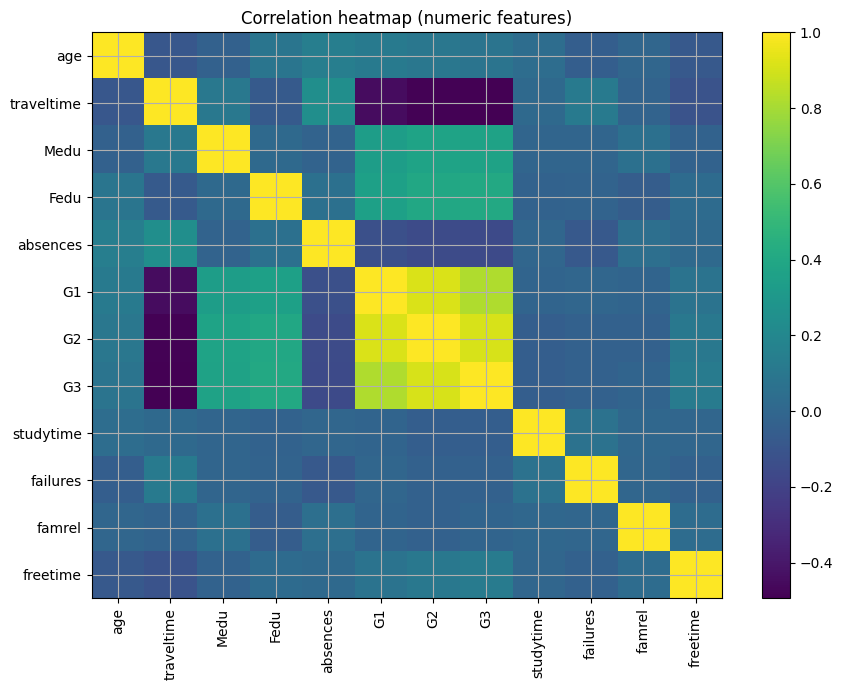

In [4]:
numeric_df = base.select_dtypes(include=[np.number]).copy()
corr = numeric_df.corr()

student_corr = corr["absences"] if "absences" in corr.columns else pd.Series(dtype=float)

print("student_corr shape:", student_corr.shape)
display(student_corr.sort_values().round(3))

# A compact heatmap without seaborn (matplotlib imshow)
plt.figure(figsize=(9, 7))
mat = corr.values
plt.imshow(mat, aspect="auto")
plt.title("Correlation heatmap (numeric features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

### Practical significance (simple rule-of-thumb)

In [5]:
if not student_corr.empty:
    abs_corr = student_corr.drop(index=["absences"], errors="ignore").abs().sort_values(ascending=False)
    top_var = abs_corr.index[0]
    top_val = float(abs_corr.iloc[0])

    # Practical threshold chosen for interpretability (not a statistical p-value)
    if top_val >= 0.30:
        existen = "YES"
        variable = str(top_var).upper()
    else:
        existen = "NO"
        variable = "NO"

    print("Top absolute correlation vs absences:", top_var, "=", round(top_val, 3))
    print("existen:", existen)
    print("variable:", variable)
else:
    existen = "NO"
    variable = "NO"
    print("No 'absences' column found; existen='NO', variable='NO'")

Top absolute correlation vs absences: traveltime = 0.243
existen: NO
variable: NO


## 4) Grouped summaries (school, gender, guardian, travel time)

In [6]:
# School / gender mean absences (common reporting cuts)
if "school" in base.columns and "absences" in base.columns:
    escuela_promedio = base.groupby("school")["absences"].mean().reset_index()
else:
    escuela_promedio = pd.DataFrame(columns=["school", "absences"])

if "sex" in base.columns and "absences" in base.columns:
    genero_promedio = base.groupby("sex")["absences"].mean().reset_index()
else:
    genero_promedio = pd.DataFrame(columns=["sex", "absences"])

print("Absences mean by school:")
display(escuela_promedio)

print("Absences mean by gender:")
display(genero_promedio)

# Guardian cut: grades & absences
if set(["guardian", "G1", "G2", "G3", "absences"]).issubset(base.columns):
    guardian_stats = base.groupby("guardian")[["G1", "G2", "G3", "absences"]].agg(["mean", "median", "std"]).round(3)
    print("Guardian summary stats:")
    display(guardian_stats)

Absences mean by school:


,school,absences
0,GP,5.119355
1,MS,5.164706


Absences mean by gender:


,sex,absences
0,F,5.167442
1,M,5.083333


Guardian summary stats:


G1                    G2                    G3                \
            mean median    std    mean median    std    mean median    std   
guardian                                                                     
father    12.358   13.0  3.798  12.242   12.0  3.554  12.253   13.0  3.629   
mother    12.211   12.0  3.548  12.259   12.0  3.217  12.230   12.0  3.228   
other     12.167   13.0  3.761  11.600   12.0  2.931  11.767   12.0  3.104   

         absences                
             mean median    std  
guardian                         
father      5.411    5.0  3.089  
mother      4.989    5.0  2.884  
other       5.500    5.5  3.432

## 5) Perfect attendance contingency table (Medu × Fedu)

In [7]:
if "absences" in base.columns:
    base["attended_all_days"] = (base["absences"] == 0)
else:
    base["attended_all_days"] = False

if set(["Medu", "Fedu"]).issubset(base.columns):
    perfect = base[base["attended_all_days"]]
    tabla_student = pd.crosstab(perfect["Medu"], perfect["Fedu"])
    tabla_student = tabla_student.reindex(index=range(5), columns=range(5), fill_value=0)
else:
    tabla_student = pd.DataFrame()

print("tabla_student (perfect attendance counts):")
display(tabla_student)

tabla_student (perfect attendance counts):


Fedu,0,1,2,3,4
Medu,,,,,
0,0,1,0,0,1
1,1,1,4,1,0
2,1,5,2,4,1
3,1,3,3,2,2
4,1,0,6,2,2


## 6) Portfolio visuals

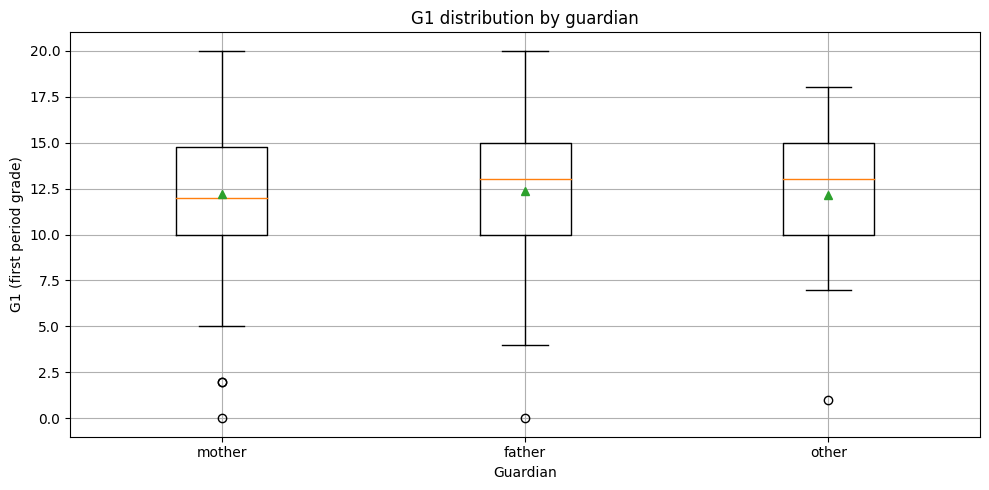

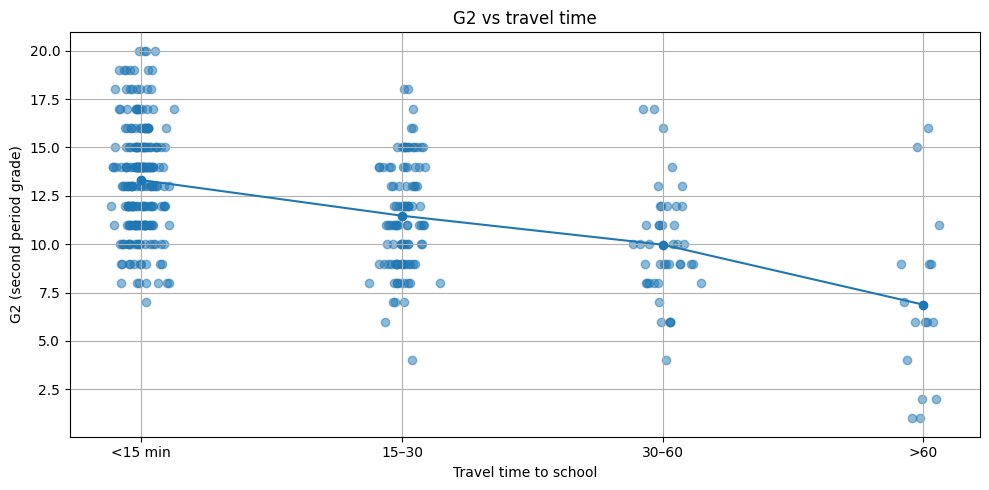

G2 mean by travel time:


,traveltime,G2_mean
0,1,13.314655
1,2,11.471154
2,3,9.976744
3,4,6.875000


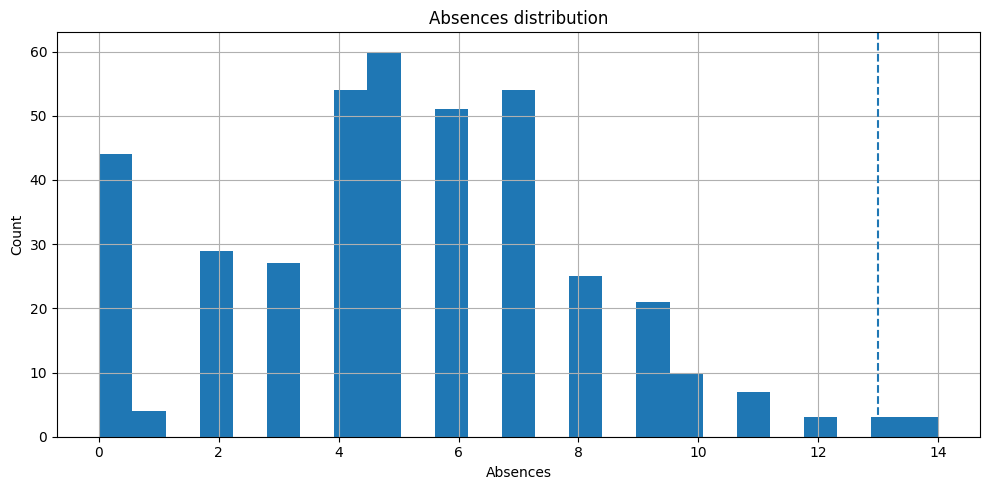

IQR outlier threshold (Q3 + 1.5*IQR): 13.0
Outlier rate: 0.0076


In [8]:
# Visual A: G1 distribution by guardian (boxplot)
if set(["guardian", "G1"]).issubset(base.columns):
    groups = ["mother", "father", "other"]
    available = [g for g in groups if g in base["guardian"].unique()]
    data = [base.loc[base["guardian"] == g, "G1"].values for g in available]

    plt.figure()
    plt.boxplot(data, labels=available, showmeans=True)
    plt.title("G1 distribution by guardian")
    plt.xlabel("Guardian")
    plt.ylabel("G1 (first period grade)")
    plt.tight_layout()
    plt.show()

# Visual B: G2 vs travel time (scatter + group mean)
if set(["traveltime", "G2"]).issubset(base.columns):
    x = base["traveltime"].astype(float).values
    x_j = x + rng.normal(0, 0.05, size=len(x))
    y = base["G2"].values

    plt.figure()
    plt.scatter(x_j, y, alpha=0.5)
    plt.xticks([1,2,3,4], ["<15 min", "15–30", "30–60", ">60"])
    plt.xlabel("Travel time to school")
    plt.ylabel("G2 (second period grade)")
    plt.title("G2 vs travel time")

    means = base.groupby("traveltime")["G2"].mean().reindex([1,2,3,4])
    plt.plot([1,2,3,4], means.values, marker="o")
    plt.tight_layout()
    plt.show()

    print("G2 mean by travel time:")
    display(means.reset_index().rename(columns={"G2":"G2_mean"}))

# Visual C: Absences distribution + outliers (hist + threshold markers)
if "absences" in base.columns:
    plt.figure()
    plt.hist(base["absences"], bins=25)
    plt.title("Absences distribution")
    plt.xlabel("Absences")
    plt.ylabel("Count")

    q1 = base["absences"].quantile(0.25)
    q3 = base["absences"].quantile(0.75)
    iqr = q3 - q1
    out_thr = q3 + 1.5 * iqr

    plt.axvline(out_thr, linestyle="--")
    plt.tight_layout()
    plt.show()

    print("IQR outlier threshold (Q3 + 1.5*IQR):", float(round(out_thr, 2)))
    print("Outlier rate:", float(round((base["absences"] > out_thr).mean(), 4)))

## 7) Extra: lightweight baseline model for final grade (G3)

Baseline model: RandomForestRegressor
MAE: 1.207
R²: 0.829


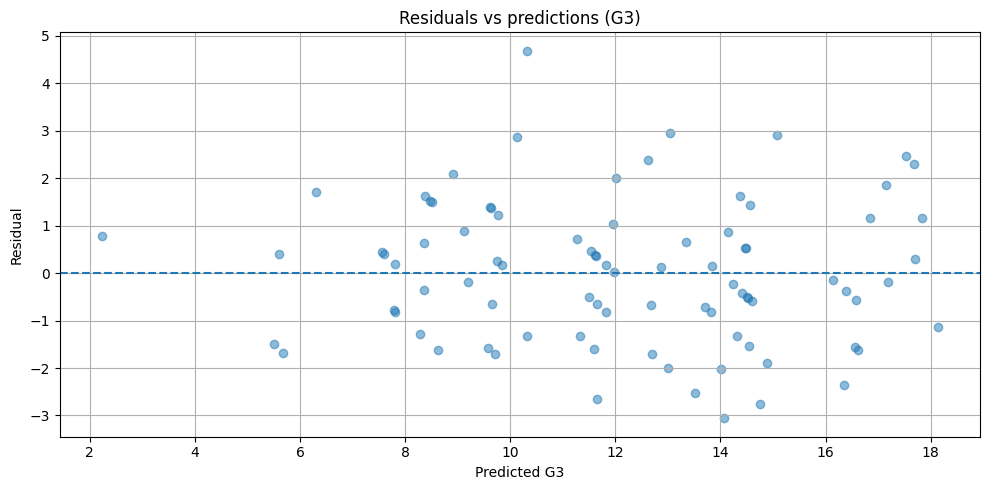

In [9]:
# Optional: quick baseline using scikit-learn if available.
# Goal: demonstrate feature prep + evaluation, not optimize performance.

try:
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import mean_absolute_error, r2_score
    from sklearn.ensemble import RandomForestRegressor

    model_ready = set(["G3", "G1", "G2", "absences"]).issubset(base.columns)

    if model_ready:
        X = base.drop(columns=["G3"]).copy()
        y = base["G3"].astype(float)

        cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

        pre = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
                ("num", "passthrough", num_cols),
            ]
        )

        pipe = Pipeline(
            steps=[
                ("preprocess", pre),
                ("model", RandomForestRegressor(n_estimators=250, random_state=RANDOM_SEED)),
            ]
        )

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=RANDOM_SEED)

        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)

        print("Baseline model: RandomForestRegressor")
        print("MAE:", round(mae, 3))
        print("R²:", round(r2, 3))

        # Residuals plot
        resid = y_test.values - pred
        plt.figure()
        plt.scatter(pred, resid, alpha=0.5)
        plt.axhline(0, linestyle="--")
        plt.title("Residuals vs predictions (G3)")
        plt.xlabel("Predicted G3")
        plt.ylabel("Residual")
        plt.tight_layout()
        plt.show()
    else:
        print("Model section skipped: required columns not found (need at least G3, G1, G2, absences).")

except Exception as e:
    print("Model section skipped (scikit-learn not available or error).")
    print("Error:", repr(e))

## 8) Save key figures (ready for a second deliverable)

In [10]:
OUTDIR = "student_portfolio_outputs"
os.makedirs(OUTDIR, exist_ok=True)

saved = []

# Save G1 by guardian
if set(["guardian", "G1"]).issubset(base.columns):
    groups = ["mother", "father", "other"]
    available = [g for g in groups if g in base["guardian"].unique()]
    data = [base.loc[base["guardian"] == g, "G1"].values for g in available]

    plt.figure()
    plt.boxplot(data, labels=available, showmeans=True)
    plt.title("G1 distribution by guardian")
    plt.xlabel("Guardian")
    plt.ylabel("G1 (first period grade)")
    plt.tight_layout()
    p = os.path.join(OUTDIR, "viz_g1_by_guardian.png")
    plt.savefig(p, dpi=170)
    plt.close()
    saved.append(p)

# Save G2 vs travel time
if set(["traveltime", "G2"]).issubset(base.columns):
    x = base["traveltime"].astype(float).values
    x_j = x + rng.normal(0, 0.05, size=len(x))
    y = base["G2"].values
    means = base.groupby("traveltime")["G2"].mean().reindex([1,2,3,4])

    plt.figure()
    plt.scatter(x_j, y, alpha=0.5)
    plt.xticks([1,2,3,4], ["<15 min", "15–30", "30–60", ">60"])
    plt.xlabel("Travel time to school")
    plt.ylabel("G2 (second period grade)")
    plt.title("G2 vs travel time")
    plt.plot([1,2,3,4], means.values, marker="o")
    plt.tight_layout()
    p = os.path.join(OUTDIR, "viz_g2_vs_traveltime.png")
    plt.savefig(p, dpi=170)
    plt.close()
    saved.append(p)

# Save correlation heatmap
numeric_df = base.select_dtypes(include=[np.number]).copy()
if numeric_df.shape[1] >= 2:
    corr = numeric_df.corr()
    plt.figure(figsize=(9, 7))
    plt.imshow(corr.values, aspect="auto")
    plt.title("Correlation heatmap (numeric features)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    p = os.path.join(OUTDIR, "viz_corr_heatmap.png")
    plt.savefig(p, dpi=170)
    plt.close()
    saved.append(p)

print("Saved", len(saved), "files:")
for p in saved:
    print("-", p)

print("\nDirectory listing:")
print(sorted(os.listdir(OUTDIR)))

Saved 3 files:
- student_portfolio_outputs/viz_g1_by_guardian.png
- student_portfolio_outputs/viz_g2_vs_traveltime.png
- student_portfolio_outputs/viz_corr_heatmap.png

Directory listing:
['viz_corr_heatmap.png', 'viz_g1_by_guardian.png', 'viz_g2_vs_traveltime.png']
